In [1]:
%load_ext autoreload
%autoreload 2

import seaborn as sns
sns.set_theme(style="ticks", palette="deep")

from matplotlib import pyplot as plt
import numpy as np
from pathlib import Path
import ruamel.yaml as yaml
import torch
import scipy.stats as stats

from soul_gan.datasets.utils import get_dataset, prepare_2d_gaussian_grid_data, prepare_2d_ring_data

from soul_gan.utils.general_utils import DotConfig, CONFIGS_DIR, DATA_DIR
from soul_gan.models.utils import GANWrapper

2022-04-02 13:27:38.810321: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
config = DotConfig(yaml.round_trip_load(Path(CONFIGS_DIR, 'gan_configs/ring-mlp.yml').open('r'))).gan_config

mean = np.array(config.train_transform.Normalize.mean)
std = np.array(config.train_transform.Normalize.std)

In [3]:
sigma = 0.02
n_modes = 8
rad = 2
sample, modes = prepare_2d_ring_data(int(5e3), sigma=sigma, n_modes=n_modes, rad=rad)
#modes = modes[:1]
dists = np.linalg.norm(modes[:, None] - modes[None, :], ord=2, axis=-1)
dists += dists.max() * np.eye(dists.shape[0])
eps = dists.min(-1)

np.savez(
    Path(DATA_DIR, f'{n_modes}_gaussians_modes.npz').open('wb'), 
    centroids=(modes - mean[None, :]) / std[None, :], 
    closest_pts=(modes - mean[None, :]) / std[None, :], 
    sigmas=np.ones(len(modes))*sigma / std[0],
    priors=np.ones(len(modes)) / len(modes),
    eps=eps,
)


In [4]:
kind = 'ring'

dataset = get_dataset(f"gaussians_{kind}", int(5e3))
dataset["dataset"]

In [5]:
import matplotlib.image as mpimg

def plot(target, feature, step_size, suffix='', step=1000):
    path = Path(f'../log/{feature}_{target}Target/mlp_{kind}{suffix}_{step_size}')
    # xs = np.load(Path(path, f'images/{step}.npy'))

    # plt.figure(figsize=(4, 4))
    # plt.scatter(xs[:, 0], xs[:, 1], alpha=0.1, s=10)

    # plt.scatter(modes[:, 0], modes[:, 1], color='r', marker='x')
    # plt.axis('equal')
    # plt.grid()

    # Path(path, 'figs').mkdir(exist_ok=True)
    # plt.savefig(Path(path, f'figs/{kind}{suffix}_{step_size}_2d_{step}.png'))
    fig_path = Path(path, 'figs', f'mlp_{kind}{suffix}_{step_size}_2d_{step}.png')
    im = mpimg.imread(fig_path)
    plt.imshow(im)
    plt.axis('off')

    emd = np.loadtxt(Path(path, 'EMD.txt'))[:, 0 if step == 0 else 1]
    std = emd.std(ddof=1)
    emd = emd.mean()
    print(fr'{emd:.3f} ± {2*std:.3f}')

2.112 ± 0.077


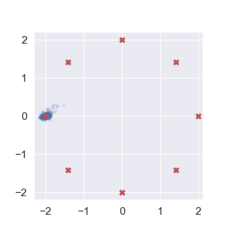

In [6]:
step_size = 0.001
target = 'Discriminator'
feature = 'dumb_feature'

plot(target, feature, step_size, step=0)

2.201 ± 0.018


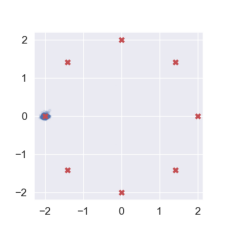

In [7]:
step_size = 0.001
target = 'Discriminator'
feature = 'dumb_feature'

plot(target, feature, step_size)

2.195 ± 0.095


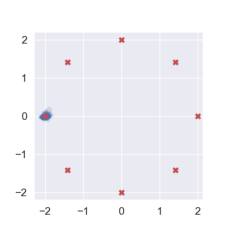

In [8]:
step_size = 0.001
target = 'Discriminator'
feature = 'cluster_feature'

plot(target, feature, step_size)

In [9]:
# step_size = 0.001
# target = 'Discriminator'
# feature = 'cluster_feature'

# plot(target, feature, step_size, suffix='_dis')

1.523 ± 0.092


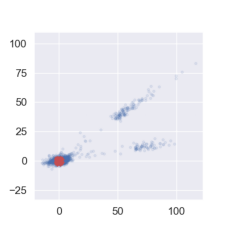

In [10]:
step_size = 0.001

target = 'Discriminator'
feature = 'discriminator_feature'

plot(target, feature, step_size)

1.820 ± 0.073


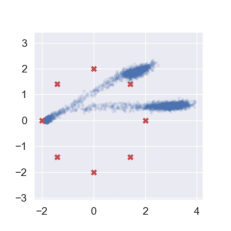

In [11]:
step_size = 0.001
target = 'Discriminator'
feature = 'cluster_feature'

plot(target, feature, step_size, suffix='_v1')


1.493 ± 0.005


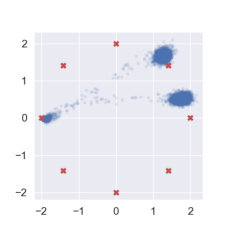

In [59]:
step_size = 0.001
target = 'Discriminator'
feature = 'cluster_feature'

plot(target, feature, step_size, suffix='_v1_dis')


2.032 ± 0.065


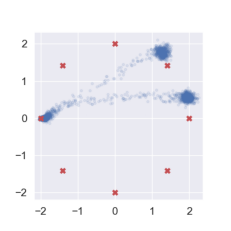

In [60]:
step_size = 0.001
target = 'Discriminator'
feature = 'cluster_feature'

plot(target, feature, step_size, suffix='_v2')


In [61]:
# step_size = 0.001
# target = 'Discriminator'
# feature = 'cluster_feature'

# plot(target, feature, step_size, suffix='_v2_lin')

In [62]:
# step_size = 0.001
# target = 'Discriminator'
# feature = 'cluster_feature'

# plot(target, feature, step_size, suffix='_v2_quad')

1.940 ± 0.069


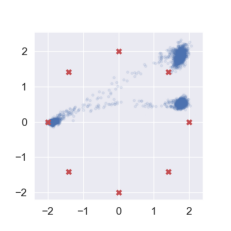

In [63]:
step_size = 0.001
target = 'Discriminator'
feature = 'cluster_feature'

plot(target, feature, step_size, suffix='_v2_dis', step=1000)

In [64]:
# step_size = 0.001
# target = 'Discriminator'
# feature = 'cluster_feature'

# plot(target, feature, step_size, suffix='_v2_lin_dis', step=1000)

In [65]:
# step_size = 0.001
# target = 'Discriminator'
# feature = 'cluster_feature'

# plot(target, feature, step_size, suffix='_v2_quad_dis', step=1000)

In [66]:
# step_size = 0.001
# target = 'Discriminator'
# feature = 'cluster_feature'

# plot(target, feature, step_size, suffix='_v3', step=1000)

In [67]:
# step_size = 0.001
# target = 'Discriminator'
# feature = 'cluster_feature'

# plot(target, feature, step_size, suffix='_v3_dis', step=1000)

2.225 ± 0.064


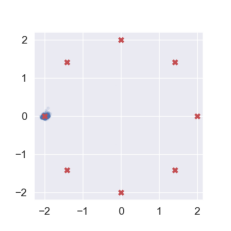

In [68]:
step_size = 0.001
target = 'Discriminator'
feature = 'mmd_feature'

plot(target, feature, step_size, suffix='', step=1000)

In [69]:
# step_size = 0.001
# target = 'Discriminator'
# feature = 'mmd_feature'

# plot(target, feature, step_size, suffix='_lin', step=1000)

In [70]:
# step_size = 0.001
# target = 'Discriminator'
# feature = 'mmd_feature'

# plot(target, feature, step_size, suffix='_quad', step=1000)

2.221 ± 0.032


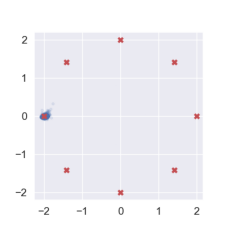

In [71]:
step_size = 0.001
target = 'Discriminator'
feature = 'mmd_feature'

plot(target, feature, step_size, suffix='_dis', step=1000)

In [72]:
# step_size = 0.001
# target = 'Discriminator'
# feature = 'mmd_feature'

# plot(target, feature, step_size, suffix='_lin_dis', step=1000)

In [73]:
# step_size = 0.001
# target = 'Discriminator'
# feature = 'mmd_feature'

# plot(target, feature, step_size, suffix='_quad_dis', step=1000)

2.228 ± 0.035


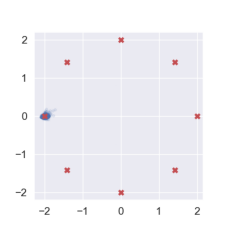

In [74]:
step_size = 0.001
target = 'Discriminator'
feature = 'cmd_feature'

plot(target, feature, step_size, suffix='', step=1000)

2.146 ± 0.057


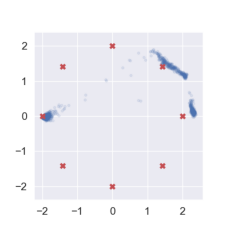

In [75]:
step_size = 0.001
target = 'Discriminator'
feature = 'cmd_feature'

plot(target, feature, step_size, suffix='_dis', step=1000)

In [29]:
device = torch.device(0)

config = DotConfig(yaml.round_trip_load(Path(CONFIGS_DIR, 'gan_configs/ring-mlp.yml').open('r'))).gan_config
gan = GANWrapper(config, device)
gen = gan.gen
dis = gan.dis

In [30]:
n_pts_ax = 100
n_kde_pts = 50000
latent_grid = np.meshgrid(np.linspace(-3, 3, n_pts_ax), np.linspace(-3, 3, n_pts_ax))
real_grid = np.meshgrid(np.linspace(-5, 5, n_pts_ax), np.linspace(-5, 5, n_pts_ax))

zs = gen.prior.sample((n_kde_pts,))
xs_normalized = gen(zs)
xs = gen.inverse_transform(xs_normalized).detach().cpu().numpy()
dgz = dis(xs_normalized).squeeze().detach().cpu().numpy()

reals = torch.from_numpy(np.stack(real_grid, -1).reshape(-1, 2)).to(device).float()
dgz_ = dis(dis.transform(reals)).squeeze()

reals_np = reals.detach().cpu().numpy()

In [31]:
dgz_.mean(), dgz.mean()

(tensor(-35.8799, device='cuda:0', grad_fn=<MeanBackward0>), -1.7606213)

In [32]:
kde = stats.kde.gaussian_kde(xs.transpose(1, 0))
log_probs = kde.logpdf(reals_np.transpose(1, 0))

Text(0.5, 1.0, '$-\\hat{E}(x) = \\log p_G(x) + d(x)$')

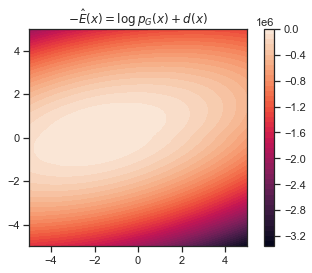

In [33]:
energy = (log_probs + dgz_.detach().cpu().numpy())
energy_grid = energy.reshape(n_pts_ax, n_pts_ax)
#Path('../figs/100gaussians').mkdir(exist_ok=True)

xs_grid = reals_np.reshape(n_pts_ax, n_pts_ax, 2)

fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.contourf(xs_grid[..., 0], xs_grid[..., 1], energy_grid, levels=50)
fig.colorbar(im)
ax.set_aspect('equal')
plt.title(r'$-\hat{E}(x) = \log p_G(x) + d(x)$')
#plt.savefig(Path('../figs/100gaussians', 'minus_energy_sigma_0.025.png'))

Text(0.5, 1.0, '$\\log p_G(x)$')

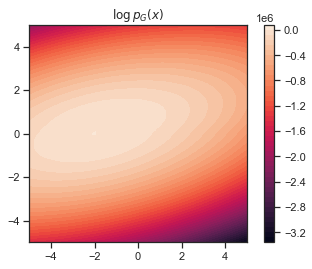

In [34]:
xs_grid = reals_np.reshape(n_pts_ax, n_pts_ax, 2)

fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.contourf(xs_grid[..., 0], xs_grid[..., 1], log_probs.reshape(n_pts_ax, n_pts_ax), levels=50)
fig.colorbar(im)
ax.set_aspect('equal')
plt.title(r'$\log p_G(x)$')
# plt.savefig(Path('../figs/100gaussians', 'log_prob_0.025.png'))

Text(0.5, 1.0, '$d(x)$')

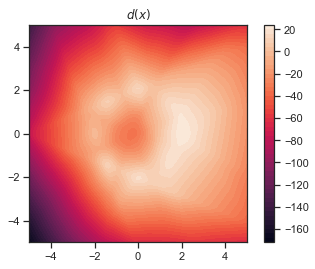

In [35]:
xs_grid = reals_np.reshape(n_pts_ax, n_pts_ax, 2)

fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.contourf(xs_grid[..., 0], xs_grid[..., 1], dgz_.detach().cpu().numpy().reshape(n_pts_ax, n_pts_ax), levels=50)
fig.colorbar(im)
ax.set_aspect('equal')
plt.title(r'$d(x)$')
# plt.savefig(Path('../figs/100gaussians', 'dgz_0.025.png'))

In [36]:
modes

array([[ 2.00000000e+00,  0.00000000e+00],
       [ 1.41421356e+00,  1.41421356e+00],
       [ 1.22464680e-16,  2.00000000e+00],
       [-1.41421356e+00,  1.41421356e+00],
       [-2.00000000e+00,  2.44929360e-16],
       [-1.41421356e+00, -1.41421356e+00],
       [-3.67394040e-16, -2.00000000e+00],
       [ 1.41421356e+00, -1.41421356e+00]])

In [37]:
# mode = torch.as_tensor(modes[-1]).to(device)

# loss_f = lambda z: torch.norm(mode[None, :] - gen(z), dim=-1)

# xs = []
# z = gan.prior.sample((1,)).to(device).requires_grad_(True)
# for it in range(1000):
#     xs.append(z.detach())
#     loss = loss_f(z)
#     grad = torch.autograd.grad(loss.sum(0), z)[0]
#     z = z - 1 * grad

#     if it % 10 == 0:
#         print(loss.mean().item()) 


In [38]:
xs = gen(torch.cat(xs, 0)).detach().cpu().numpy()

TypeError: cat() received an invalid combination of arguments - got (numpy.ndarray, int), but expected one of:
 * (tuple of Tensors tensors, int dim, *, Tensor out)
 * (tuple of Tensors tensors, name dim, *, Tensor out)


In [ ]:
plt.scatter(xs[:, 0], xs[:, 1])